# Effect of corpus size on similarity scores

## Data preparation

In [1]:
from svd2vec import svd2vec, FilesIO, Utils
from gensim.models import Word2Vec

import os
import time
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 5)

In [2]:
all_documents = FilesIO.load_corpus("text8")

In [3]:
def split_documents(n_corpuses=5):
    sizes = np.geomspace(len(all_documents), 15, num=n_corpuses, dtype=int)
    corpuses = [all_documents[:s] for s in sizes]
    return corpuses

In [4]:
def display_stats_corpus(corpus):
    def format_space(n):
        return '{:,}'.format(n).replace(',', ' ')
    print("=-=-=-=-=-=-=-=-=-=-=-=-")
    print("Documents: ", format_space(len(corpus)))
    print("Tokens:    ", format_space(sum([len(d) for d in corpus])))
    print("Vocabulary:", format_space(len(set.union(*[set(d) for d in corpus]))))
    print("")
def display_stats_corpuses(corpuses):
    for c in corpuses:
        display_stats_corpus(c)

In [5]:
corpuses = split_documents(n_corpuses=10)

In [6]:
display_stats_corpuses(corpuses)

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  1 701
Tokens:     17 005 208
Vocabulary: 253 855

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  1 005
Tokens:     10 050 000
Vocabulary: 189 702

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  594
Tokens:     5 940 000
Vocabulary: 138 809

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  351
Tokens:     3 510 000
Vocabulary: 104 471

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  207
Tokens:     2 070 000
Vocabulary: 79 693

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  122
Tokens:     1 220 000
Vocabulary: 59 551

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  72
Tokens:     720 000
Vocabulary: 42 215

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  42
Tokens:     420 000
Vocabulary: 30 242

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  25
Tokens:     250 000
Vocabulary: 22 309

=-=-=-=-=-=-=-=-=-=-=-=-
Documents:  15
Tokens:     150 000
Vocabulary: 15 624



In [7]:
sizes = [sum([len(d) for d in corpus]) for corpus in corpuses]

## Training embeddings

In [8]:
size = 300
window = 5
min_count = np.logspace(2, 0, num=len(corpuses), dtype=int)

In [9]:
def train_embeddings_generic(corpuses, name, method):
    models = []
    total  = len(corpuses)
    start = time.time()
    for i, documents in enumerate(corpuses):
        print("Building", name, "embeddings", i + 1, "out of", total, "... ", end="", flush=True)
        s = time.time()
        if name == "svd":
            model = method(documents, size=size, window=window, min_count=min_count[i], workers=16, sub_threshold=1e-3, neg_k_shift=1)
        else:
            model = method(documents, size=size, window=window, min_count=min_count[i], workers=16)            
        models.append(model)
        print(time.time() - s, "s")
    end = time.time()
    print("Total time:", end-start, "s")
    return models

def train_embeddings_svd(corpuses):
    return train_embeddings_generic(corpuses, "svd", svd2vec)

def train_embeddings_w2v(corpuses):
    return train_embeddings_generic(corpuses, "w2v", Word2Vec)

In [17]:
BUILD_MODEL_SCRATCH = False

In [18]:
def save(models, name, ext):
    for i, model in enumerate(models):
        model.save(name + str(i + 1) + "." + ext)
def load(indexes, module, name, ext):
    return [module.load(name + str(i + 1) + "." + ext) for i in indexes]

if BUILD_MODEL_SCRATCH:
    svd_models = train_embeddings_svd(corpuses)
    save(svd_models, "svd_model_", "svd")
    
    w2v_models = train_embeddings_w2v(corpuses)
    save(w2v_models, "w2v_model_", "w2v")
else:
    svd_models = load(range(len(corpuses)), svd2vec, "svd_model_", "svd")
    w2v_models = load(range(len(corpuses)), Word2Vec, "w2v_model_", "w2v")

## Evaluation

In [19]:
files = [
    FilesIO.path('similarities/wordsim353.txt'),
    FilesIO.path('similarities/men_dataset.txt'),
    FilesIO.path('similarities/mturk.txt'),
    FilesIO.path('similarities/simlex999.txt'),
    FilesIO.path('similarities/rarewords.txt')
]

In [20]:
from scipy import stats
stats.spearmanr = Utils.confidence_pearson

def models_get_score(models, file):
    scores = []
    confidences = []
    for model in models:
        try:
            if hasattr(model, 'wv'):
                pearson, (score, p_value, low, high), oov_ratio = model.wv.evaluate_word_pairs(file)
                confidence = (score - low, high - score)
            else:
                score, p_value, (low, high) = model.evaluate_word_pairs(file)
                confidence = (score - low, high - score)
        except ValueError as e:
            score = 0
            confidence = (0, 0)
        scores.append(score)
        confidences.append(confidence)
    return scores, np.array(confidences).T

def scores_dataframe(all_models, all_models_names, file):
    df = pd.DataFrame()
    confidences = []
    for i, models in enumerate(all_models):
        df[all_models_names[i]], c = models_get_score(models, file)
        confidences.append(c)
    df["tokens"] = sizes
    df.set_index("tokens", inplace=True)
    return df, np.array(confidences)

def scores_dataframes(all_models, all_models_names, files):
    return [scores_dataframe(all_models, all_models_names, file) for file in files]

In [21]:
scores = scores_dataframes([svd_models, w2v_models], ["svd", "w2v"], files)

In [22]:
def plot_dataframes(dfs, names):
    for i, (df, errors) in enumerate(dfs):
        ax = df.plot(style='-', yerr=errors)
        
        low_svd = df["svd"] - errors[0][0]
        hig_svd = errors[0][1] + df["svd"]
        
        low_w2v = df["w2v"] - errors[1][0]
        hig_w2v = errors[1][1] + df["w2v"]
        
        ax.fill_between(df.index, low_svd, hig_svd, alpha=.05, color='#1f77b4')
        ax.fill_between(df.index, low_w2v, hig_w2v, alpha=.05, color='#ff7f0e')
        
        ax.set_ylim(0,1)
        ax.set_title(names[i])
        ax.set_xlabel("learning corpus tokens")
        ax.set_ylabel("pearson similarity coefficient")
        ax.grid(color='gray', linestyle='-', linewidth=0.5)

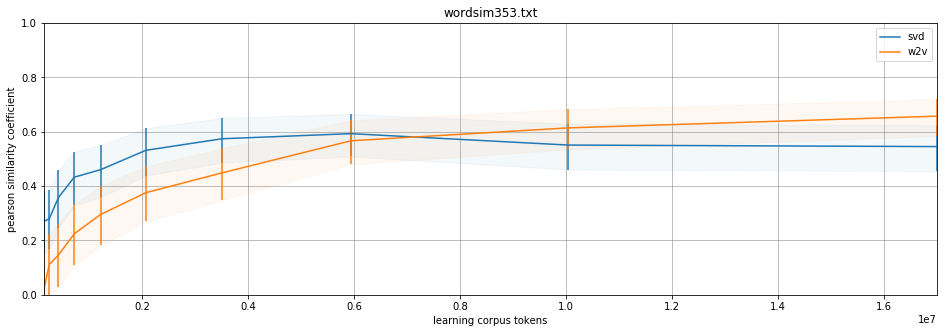

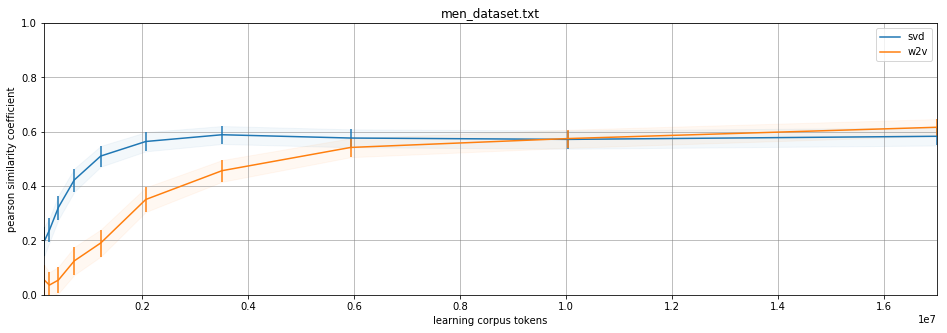

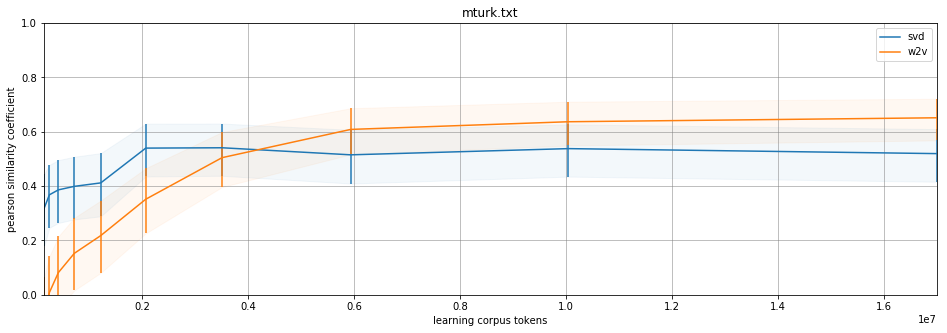

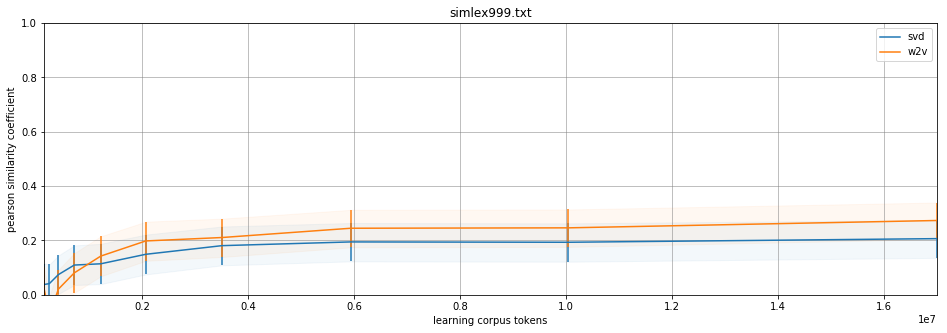

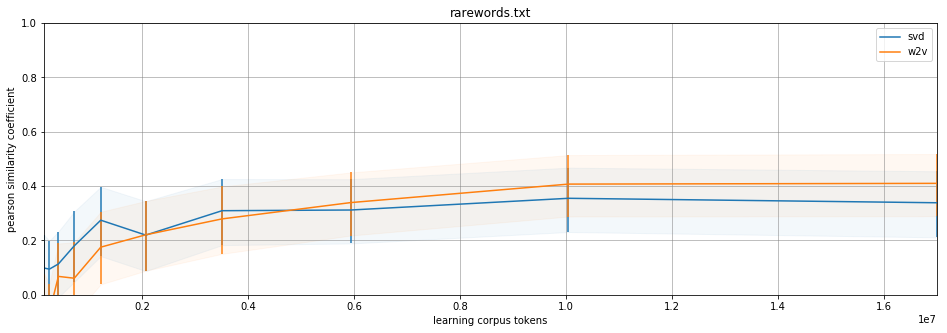

In [23]:
plot_dataframes(scores, [os.path.basename(f) for f in files])